# Seeds: Random effect logistic regression

Floran Defossez, Sebastien Roig, Gatien Chopard, Natacha Gougeon

## Description des données

A travers ce jeu de données, nous étudions la germination de graines sur un total de 21 assiettes. Deux types de graines sont testés (seed O. aegyptiaco 75 et seed O. aegyptiaco 73) ainsi que deux racines (haricot et concombre), résultant en un total de 4 combinaisons type de graine/racine testées.

## Description du modèle

## Implémentation

In [15]:
import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt

In [13]:
def pi(alpha0, alpha1, alpha2, alpha12, bi, x1, x2):
    s = alpha0 + alpha1*x1 + alpha2*x2 + alpha12*x1*x2 + bi
    return 1/(1+np.exp(-s))

def log_vraisemblance(data, alpha0, alpha1, alpha2, alpha12, b):
    r, n, x1, x2 = data
    N=len(r)
    vraisemblance = 0
    for i in range(N):
        vraisemblance += r[i]*np.log(pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i]))
        vraisemblance += (n[i] - r[i])*(np.log(1 - pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i])))
    return vraisemblance


def gibbs_seed(nchain, hyper, init1, init_bi, data):
    chain1 = np.zeros(shape = (nchain+1, 5)) #alpha0, alpha1, alpha2, alpha12, tau
    chain_bi = np.zeros(shape = (nchain+1, 21)) #bi

    chain1[0,:] = init1
    chain_bi[0,:] = init_bi

    sigma0, sigma1, sigma2, sigma12, alpha, beta = hyper #variances pour les lois normales des alpha et alpha/beta de l'inverse gamma pour tau

    N = 21

    for i in range(nchain):

        #mise à jour des bi
        for j in range(N):
            xt = chain_bi[i,j]
            prop = xt + np.random.normal()

            b_prop = np.copy(chain_bi[i]) #vecteur des bi dans lequel on remplace bj par la proposition
            b_prop[j] = prop

            num = -prop**2/(2*chain1[i, 4]) + log_vraisemblance(data, chain1[i,0], chain1[i,1], chain1[i,2], chain1[i,3], b_prop)
            den = -xt**2/(2*sigma0) + log_vraisemblance(data, chain1[i,0], chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i])
            
            prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
            if prob_acceptation > np.random.uniform():
                chain_bi[i+1, j] = prop
            else :
                chain_bi[i+1, j] = xt

        #mise à jour de alpha0
        xt = chain1[i,0]
        prop = xt + np.random.normal()

        num = -prop**2/(2*sigma0) + log_vraisemblance(data, prop, chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i])
        den = -xt**2/(2*sigma0) + log_vraisemblance(data, xt, chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 0] = prop
        else :
            chain1[i+1, 0] = xt

        #mise à jour de alpha1
        xt = chain1[i,1]
        prop = xt + np.random.normal()

        num = -prop**2/(2*sigma1) + log_vraisemblance(data, chain1[i,0], prop, chain1[i,2], chain1[i,3], chain_bi[i])
        den = -xt**2/(2*sigma1) + log_vraisemblance(data, chain1[i,0], xt, chain1[i,2], chain1[i,3], chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 1] = prop
        else :
            chain1[i+1, 1] = xt

        #mise à jour de alpha2
        xt = chain1[i,2]
        prop = xt + np.random.normal()

        num = -prop**2/(2*sigma2) + log_vraisemblance(data, chain1[i,0], chain1[i,1], prop, chain1[i,3], chain_bi[i])
        den = -xt**2/(2*sigma2) + log_vraisemblance(data, chain1[i,0], chain1[i,1], xt, chain1[i,3], chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 2] = prop
        else :
            chain1[i+1, 2] = xt

        #mise à jour de alpha12
        xt = chain1[i,3]
        prop = xt + np.random.normal()

        num = -prop**2/(2*sigma12) + log_vraisemblance(data, chain1[i,0], chain1[i,1], chain1[i,2], prop, chain_bi[i])
        den = -xt**2/(2*sigma12) + log_vraisemblance(data, chain1[i,0], chain1[i,1], chain1[i,2], xt, chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 3] = prop
        else :
            chain1[i+1, 3] = xt

        #mise à jour de tau
        alpha_star = alpha + N/2
        beta_star = beta + np.sum(chain_bi[i]**2)/2
        chain1[i+1, 4] = invgamma.rvs(a = alpha_star, scale = beta_star)

    return chain1, chain_bi

In [17]:
r = np.array([10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3])
n = np.array([39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7])
x1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #seed type (seed 75 ou seed 73)
x2 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) #root extract (bean ou cucumber)

data = np.array([r, n, x1, x2])
print(data)
print(np.shape(data))

hyper = [10**6, 10**6, 10**6, 10**6, 1, 1] #sigma0, sigma1, sigma2, sigma12 (tous déja au carré), alpha, beta
init1 = [1, 1, 1, 1, 1]
init_bi = np.ones(len(r))
nchain = 1000

[[10 23 23 26 17  5 53 55 32 46 10  8 10  8 23  0  3 22 15 32  3]
 [39 62 81 51 39  6 74 72 51 79 13 16 30 28 45  4 12 41 30 51  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  1  1  1  1  1  1  0  0  0  0  0  1  1  1  1  1]]
(4, 21)


In [14]:
chain1, chain_bi = gibbs_seed(nchain = nchain, hyper = hyper, init1 = init1, init_bi = init_bi, data = data)

Text(0.5, 1.0, 'Alpha12')

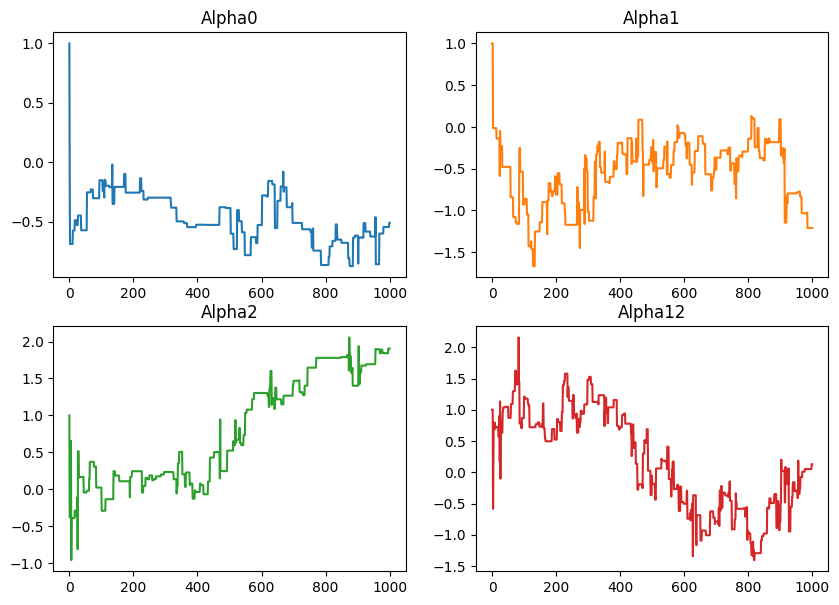

In [31]:
x = np.arange(nchain+1)

fig, axs = plt.subplots(2, 2, figsize = (10, 7))
axs[0, 0].plot(x, chain1[:,0])
axs[0, 0].set_title('Alpha0')
axs[0, 1].plot(x, chain1[:,1], 'tab:orange')
axs[0, 1].set_title('Alpha1')
axs[1, 0].plot(x, chain1[:,2], 'tab:green')
axs[1, 0].set_title('Alpha2')
axs[1, 1].plot(x, chain1[:,3], 'tab:red')
axs[1, 1].set_title('Alpha12')

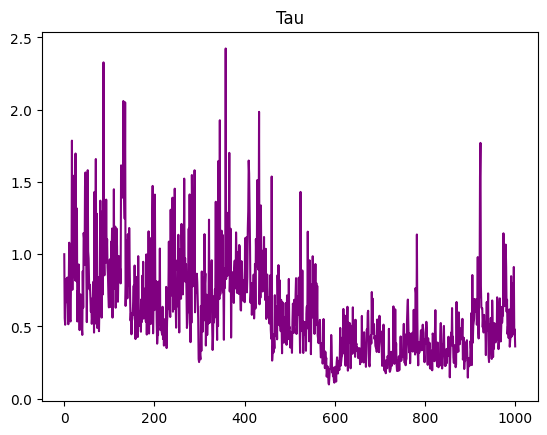

In [34]:
plt.plot(x, chain1[:,4], c='purple')
plt.title('Tau')
plt.show()

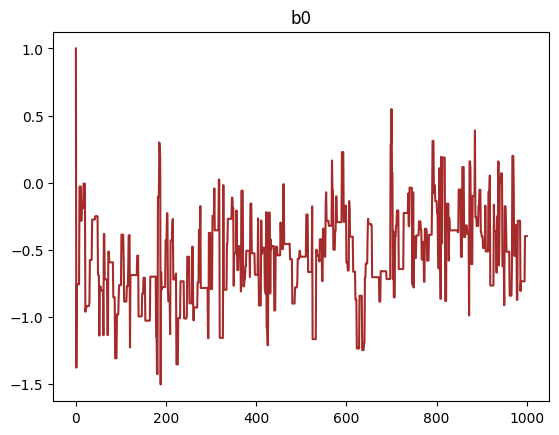

In [35]:
plt.plot(x, chain_bi[:,0], c='brown')
plt.title('b0')
plt.show()